<a href="https://colab.research.google.com/github/lucascerfig/PyTorch-experiments/blob/master/TrainingAClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


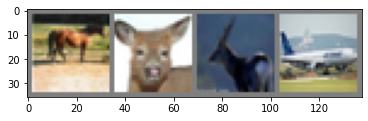

horse  deer  deer plane


In [32]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5 # Desnormalizando
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 36, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(36, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [39]:
import timeit
start = timeit.default_timer()

# Treinando em CPU
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader):
    inputs, labels = data # Obtem as entradas e seus rótulos
    optimizer.zero_grad() # Zerando os gradientes

    # Forward + backprop + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Imprime estatísticas
    running_loss += loss.item()
    if i % 2000 == 1999: # Imprime a cada 2000 mini batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0 # Zera o loss parcial
  
stop = timeit.default_timer()
print('Finished Training')
print('Runtime: %.3f' %((stop - start)/60))

[1,  2000] loss: 2.109
[1,  4000] loss: 1.749
[1,  6000] loss: 1.599
[1,  8000] loss: 1.515
[1, 10000] loss: 1.425
[1, 12000] loss: 1.392
[2,  2000] loss: 1.300
[2,  4000] loss: 1.284
[2,  6000] loss: 1.267
[2,  8000] loss: 1.220
[2, 10000] loss: 1.212
[2, 12000] loss: 1.184
Finished Training


TypeError: ignored

In [0]:
  # Salvando o modelo treinado
  PATH = './cifar_net.pth'
  torch.save(net.state_dict(), PATH)

In [0]:
dataiter = iter(testloader)

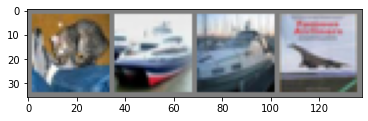

GroundTruth:    cat  ship  ship plane


In [45]:

images, labels = dataiter.next()

# Imprime as imagens
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [46]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [47]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


In [48]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [49]:
# Verificando a acurácia por classe
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 79 %
Accuracy of  bird : 34 %
Accuracy of   cat : 46 %
Accuracy of  deer : 39 %
Accuracy of   dog : 56 %
Accuracy of  frog : 73 %
Accuracy of horse : 63 %
Accuracy of  ship : 73 %
Accuracy of truck : 68 %


In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device) 

cuda:0


In [51]:
net.to(device)

Net(
  (conv1): Conv2d(3, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(36, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [52]:
import timeit
start = timeit.default_timer()

net = Net()
net.to(device)
# Treinando em GPU
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad() # Zerando os gradientes

    # Forward + backprop + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Imprime estatísticas
    running_loss += loss.item()
    if i % 2000 == 1999: # Imprime a cada 2000 mini batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0 # Zera o loss parcial
  
stop = timeit.default_timer()
print('Finished Training')
print('Runtime: %.3f' %((stop - start)/60))

[1,  2000] loss: 2.304
[1,  4000] loss: 2.305
[1,  6000] loss: 2.305
[1,  8000] loss: 2.305
[1, 10000] loss: 2.304
[1, 12000] loss: 2.303
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.305
[2,  8000] loss: 2.304
[2, 10000] loss: 2.304
[2, 12000] loss: 2.304
Finished Training
Runtime: 2.650
